In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import sys
import os.path
sys.path.append(
    os.path.abspath(os.path.dirname(os.path.abspath(''))))

from simulation import Parameters
from equations import solveDiscrete, decayLengthPhysical, get_kd, get_v
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import os

# Density on single mt:
dat = []
mt_length = 500
x = np.arange(0,mt_length*0.008,0.008)
t = np.linspace(0,100,100)

beta_start = 0.8
beta_step = 0.1

colorcoded = 'gamma'
colorcodedlabel = 'gamma and delta'
norm = matplotlib.colors.Normalize(vmin=0, vmax=1.2)

p = Parameters()
counter = 1
for filename in os.listdir('./config/'):
    for var in [0, 0.25, 0.5, 0.75, 1]:
        # p.read('./config/' + os.listdir('./config/')[5])
        p.read('./config/' + filename)
        p.beta = [0,0]#np.arange(beta_start,0,-beta_step)
        p.P_lose = 0.3
        p.omega = 0.3
        p.gamma = var
        p.delta = var
        solution = solveDiscrete(p,t,mt_length)
        velocities = np.apply_along_axis(get_v, 1, solution, p)
        v = velocities[:,0]
        accumulation = np.sum(solution-p.alpha,axis=1)
        y = solution[-1]-p.alpha
        y = y/y[0]
        d = decayLengthPhysical(p, v[-1])
        ye = np.exp(-x/d)
        a = 1 - accumulation/accumulation[-1]
        t_const = t[np.where(a < 0.367879441)[0][0]]
        print(counter, 'diff:', p.D, ' off from steady state:', (accumulation[-1]-accumulation[-2])/accumulation[-1], 
              'error in decay length:', np.max(y-ye))
        dat.append({'alpha':p.alpha, 'beta_start':beta_start, 'beta_step':beta_step, 'omega':p.omega, 'D':p.D, 'koff':p.koff, 'decay_length':d, 't_const':t_const, 'gamma': p.gamma, 'delta':p.delta,
                    'v':v, 'v_shift':velocities[:,1], 'v_lose':velocities[:,2], 'p':p, 'accumulation':accumulation, 'solution':solution, 
                    'string':str(counter) + " D=" + str(p.D) + "  alpha=" + str(p.alpha) + "  " + colorcoded + "=" + str(var)})
        counter += 1

1 diff: 0.093  off from steady state: 0.0026510787609013674 error in decay length: 0.0009119711165485045
2 diff: 0.093  off from steady state: 3.678417967406242e-05 error in decay length: 0.004076391195670326
3 diff: 0.093  off from steady state: 3.1485590452529984e-07 error in decay length: 0.0043355862539398715
4 diff: 0.093  off from steady state: -1.194022477707131e-08 error in decay length: 0.004436861819866411
5 diff: 0.093  off from steady state: 2.479081003462909e-09 error in decay length: 0.004491971302983899
6 diff: 0.093  off from steady state: 0.0014062535900982117 error in decay length: 0.0
7 diff: 0.093  off from steady state: 8.710239370032986e-05 error in decay length: 0.002739194144628865
8 diff: 0.093  off from steady state: 1.5960294756063072e-06 error in decay length: 0.0035063458757320642
9 diff: 0.093  off from steady state: 2.6647021513888133e-08 error in decay length: 0.003852509312486152
10 diff: 0.093  off from steady state: -4.996268076504793e-09 error in dec

In [4]:
import dill
# dill.load_session('notebook_env.db')

dill.dump_session('v4.db')

In [22]:
# from equations import solveDiscrete, decayLengthPhysical, get_v
# P = dat[0]["solution"][-1]
# # P[:] = p.alpha

# k0 = p.depol_rate
# p.beta = np.arange(0.8,0,-0.2)
# p.omega = 0.1
# # P = np.array([1,1,0,0,0,0,0,1])

# kd, P_shift, P_lose = get_v(P, p)

# len(dat[0]["solution"])
# fig, ax = plt.subplots()
# # np.array([kd, k0, k0 * (1.-P[0]), k0 * P[0] * (P_shift[0] + P_lose)]) * p.a

In [23]:
font = {'size'   : 18}

matplotlib.rc('font', **font)
   
cmap = cm.gist_ncar
colors = cm.ScalarMappable(norm=norm, cmap=cmap)

def setMarker(val, permitted_values):
    if val == permitted_values[0]:
        return '^'
    elif val == permitted_values[1]:
        return 'o'
    elif val == permitted_values[2]:
        return 'x'
    elif val == permitted_values[3]:
        return '>'
    
def mscatter(x,y,ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    if not ax: ax=plt.gca()
    sc = ax.scatter(x,y,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

def df(plotdic, key):
    if isinstance(plotdic[0][key], float) or isinstance(plotdic[0][key], int):
        return np.array([dic[key] for dic in plotdic])
    else:
        return np.array([dic[key][-1] for dic in plotdic])
    
def standard_plot(plotdat, xkey, ykey):
    plt.figure(figsize=(5,5))
    unique_vals = list(set([dic['D'] + dic['koff'] for dic in plotdat]))
    color = df(plotdat,colorcoded)
    mscatter(df(plotdat,xkey),
         df(plotdat,ykey), 
         c=color,
         m=[setMarker(dic['D'] + dic['koff'], unique_vals) for dic in plotdat],
         s=200, facecolors='none', alpha=0.6, norm=norm, cmap=cmap, label=color)
    matplotlib.pyplot.colorbar(colors, label = colorcodedlabel)

# colors = list(set(df(plotdat,'omega')))

def saveallfigs(name):
    plt.savefig(name + ".svg", transparent=True)
    plt.savefig(name + ".png", transparent=True, bbox_inches='tight')

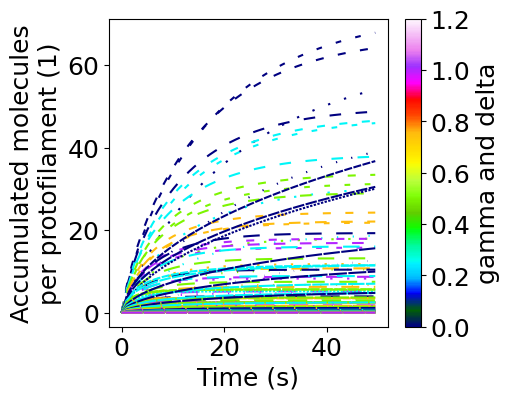

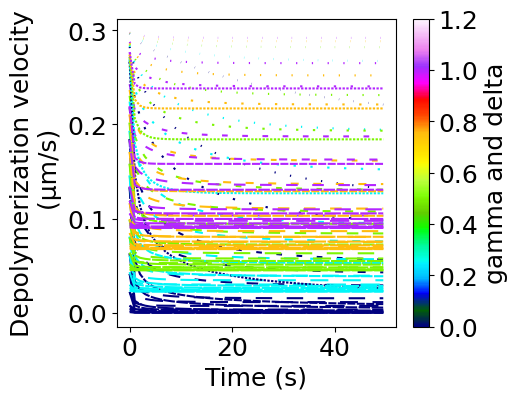

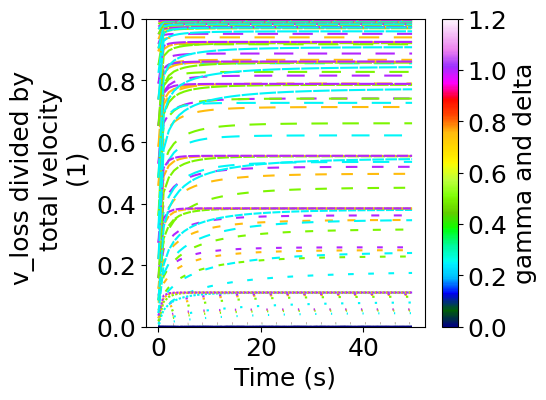

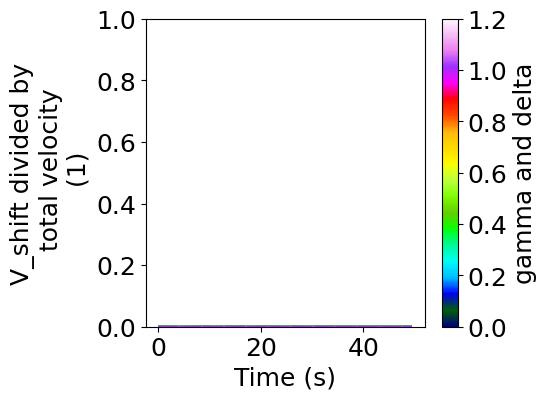

In [25]:
# filtered = list(filter(lambda condition: condition['D'] == 0.0093, plotdat))
filtered = dat#list(filter(lambda condition: 0.1 > condition['alpha'] > 0.05 and condition['D'] == 0.093, plotdat))

plt.figure(figsize=(4.5,4))
tmax = np.where(t >= 50)[0][0]
for curve in filtered:
    accumulation = curve["accumulation"]
    dash = [curve["alpha"]*10, curve["D"]*75]
    plt.plot(t[0:tmax],accumulation[0:tmax], dashes = dash, color = colors.to_rgba(curve[colorcoded]))
    
plt.xlabel("Time (s)")
plt.ylabel("Accumulated molecules\nper protofilament (1)")
plt.colorbar(colors, ax = plt.gca(), label = colorcodedlabel)
saveallfigs("figs/time vs accumulation")

plt.figure(figsize=(4.5,4))
for curve in filtered:
    v = curve["v"]
    dash = [curve["alpha"]*10, curve["D"]*75]
    plt.plot(t[0:tmax],v[0:tmax], dashes = dash, color = colors.to_rgba(curve[colorcoded]))
plt.xlabel("Time (s)")
plt.ylabel("Depolymerization velocity\n (\u03bcm/s)")
plt.colorbar(colors, ax = plt.gca(), label = colorcodedlabel)
saveallfigs("figs/time vs speed")

plt.figure(figsize=(4.5,4))
for curve in filtered:
    v = curve["v_lose"] / curve["v"] 
    dash = [curve["alpha"]*10, curve["D"]*75]
    plt.plot(t[0:tmax],v[0:tmax], dashes = dash, color = colors.to_rgba(curve[colorcoded]))
plt.xlabel("Time (s)")
plt.ylim([0, 1])
plt.ylabel("v_loss divided by \n total velocity\n (1)")
plt.colorbar(colors, ax = plt.gca(), label = colorcodedlabel)
saveallfigs("figs/time vs v_loss  divided by v")
# plt.ylim([0, 5])
# saveallfigs("figs/time vs v_loss/v")

plt.figure(figsize=(4.5,4))
for curve in filtered:
    v = curve["v_shift"] / curve["v"] 
    dash = [curve["alpha"]*10, curve["D"]*75]
    plt.plot(t[0:tmax],v[0:tmax], dashes = dash, color = colors.to_rgba(curve[colorcoded]))
plt.xlabel("Time (s)")
plt.ylim([0, 1])
plt.ylabel("V_shift divided by\n total velocity\n (1)")
plt.colorbar(colors, ax = plt.gca(), label = colorcodedlabel)
saveallfigs("figs/time vs v_shift divided by v")
# plt.ylim([0, 5])
# saveallfigs("figs/time vs velocity divided by v_shift closeup")

C:\Users\Marcel\AppData\Local\Temp\ipykernel_7448\1156435926.py:50: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  matplotlib.pyplot.colorbar(colors, label = colorcodedlabel)


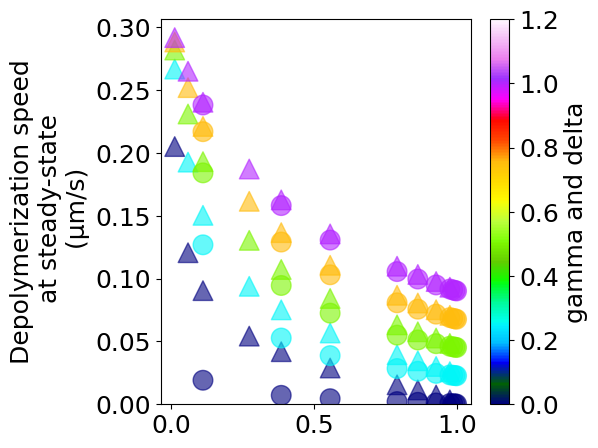

In [26]:
plotdat = dat
fig = standard_plot(plotdat, 'alpha', 'v')
plt.ylabel("Depolymerization speed\n at steady-state\n (\u03bcm/s)")
plt.ylim(0)
saveallfigs("figs/ase1 density vs depolymerization speed")

C:\Users\Marcel\AppData\Local\Temp\ipykernel_7448\1156435926.py:50: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  matplotlib.pyplot.colorbar(colors, label = colorcodedlabel)


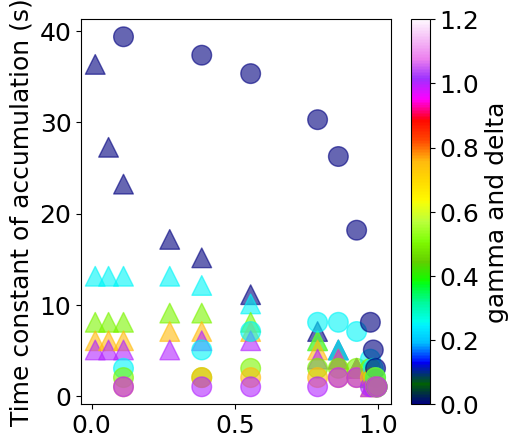

In [27]:
standard_plot(plotdat, 'alpha', 't_const')
plt.ylabel('Time constant of accumulation (s)')
# plt.xlabel("Ase1 density (1/protofilament dimer)")
# plt.ylim([0,25])
saveallfigs("figs/ase1 density vs time constant of accumulation ")

C:\Users\Marcel\AppData\Local\Temp\ipykernel_7448\1156435926.py:50: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  matplotlib.pyplot.colorbar(colors, label = colorcodedlabel)


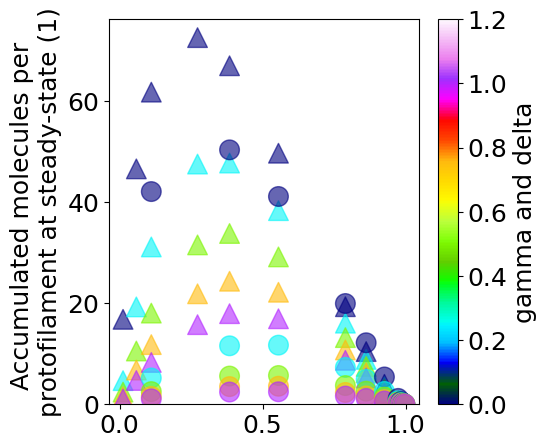

In [28]:
standard_plot(plotdat, 'alpha', 'accumulation')
plt.ylabel("Accumulated molecules per \nprotofilament at steady-state (1)")
# plt.xlabel("Ase1 density (1/protofilament dimer)")
plt.ylim(0)
saveallfigs("figs/ase1 density vs accumulated molecules")


C:\Users\Marcel\AppData\Local\Temp\ipykernel_7448\1156435926.py:50: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  matplotlib.pyplot.colorbar(colors, label = colorcodedlabel)


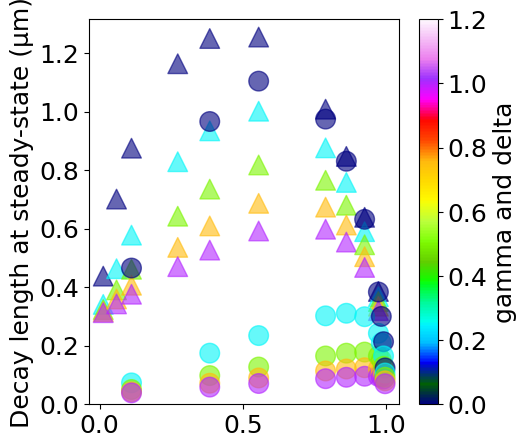

In [29]:
standard_plot(plotdat, 'alpha', 'decay_length')

plt.ylabel("Decay length at steady-state (\u03bcm)")
# plt.xlabel("Ase1 density (1/protofilament dimer)")
plt.ylim(0)
saveallfigs("figs/ase1 density vs decay length")


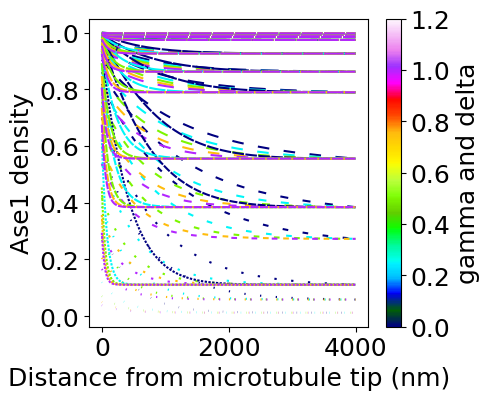

In [30]:
# filtered = list(filter(lambda condition: 0.1 > condition['alpha'] > 0.05 and condition['D'] == 0.093, plotdat))
plot = plt.figure(figsize=(4.5,4))
for curve in dat:
    solution = curve["solution"]
    y = solution[-1][:]
    dash = [curve["alpha"]*10, curve["D"]*75]
    plt.plot(x*1000,y, dashes = dash, color = colors.to_rgba(curve[colorcoded][-1] if hasattr(curve[colorcoded], "__len__") else curve[colorcoded]))

plt.xlabel("Distance from microtubule tip (nm)")
plt.ylabel("Ase1 density")
plt.colorbar(colors, ax = plt.gca(), label = colorcodedlabel)
saveallfigs("figs/distance versus Ase1 density")